In [1]:
from blportopt.config import (
    FUND_TICKERS,
    MARKET_TICKER,
    FF_FACTORS,
    ASSET_TICKERS,
)
from blportopt.data_utils import (
    get_data,
    MarketCapEvaluator,
)
from blportopt.fama_french_model import famafrench_regression_analysis
from blportopt.trading_strategy import backtest
from blportopt.covariance_estimator import (
    empirical_cov_calculate,
    factor_cov_calculate,
)
from blportopt.portfolio_construction import (
    empirical_rf_calculate,
    calc_optimal_portfolio_weights,
    efficient_frontier,
    plot_efficient_frontier,
)

# Asset Type

In [2]:
## Index Funds used in Portfolio Construction
# asset_type = "fund"

## Stocks used in Portfolio Construction
asset_type = "stock"

# 1. Load Data

In [3]:
ff_data, fund_open_data, fund_close_data, fund_returns, market_returns = get_data(asset_tickers=FUND_TICKERS, market_ticker=MARKET_TICKER, asset_type="fund")

display(ff_data.head())
display(fund_open_data.head())
display(fund_close_data.head())
display(fund_returns.head())
display(market_returns.head())

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 10 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 10 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
Date,,,,,,,
1963-07,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,0.0090
1963-08,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,0.0101
1963-09,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,0.0019
1963-10,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,0.0312
1963-11,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,-0.0074


,XLK,XLF,XLV,XLY,XLI,XLP,XLE,XLB,XLU,IYR
Date,,,,,,,,,,
2008-01,21.102577,17.070858,26.738086,26.540570,28.066698,18.277428,47.993432,29.080851,23.385230,35.673085
2008-02,18.671619,17.023889,25.042099,26.210728,26.844832,17.425373,42.332673,28.425311,21.909443,35.721921
2008-03,17.563041,15.069083,24.501779,25.092464,25.874553,17.271620,45.682332,28.585713,20.860847,34.148025
2008-04,18.153928,15.243866,23.593843,25.085247,27.202310,18.111099,44.429201,28.353168,21.374603,36.411332
2008-05,19.143996,15.705440,23.639063,25.963315,27.628249,17.917878,48.595205,29.514447,22.408397,37.854623


,XLK,XLF,XLV,XLY,XLI,XLP,XLE,XLB,XLU,IYR
Date,,,,,,,,,,
2008-01,18.410316,17.106079,25.289742,26.210724,26.593287,17.425379,41.780399,27.860432,21.759638,35.694790
2008-02,17.539286,15.163002,24.614349,25.197052,26.054222,17.380527,45.652298,28.502024,20.866400,34.196873
2008-03,17.737246,14.599459,23.391130,24.714346,26.880787,17.848196,44.457733,28.013857,21.049482,35.331158
2008-04,18.850937,15.746865,23.729527,25.334972,27.794292,17.808388,49.215271,29.598387,22.285469,37.799736
2008-05,20.078623,14.652099,24.181797,26.027761,28.039749,18.349401,51.773880,31.137426,23.084562,38.107059


,XLK,XLF,XLV,XLY,XLI,XLP,XLE,XLB,XLU,IYR
Date,,,,,,,,,,
2008-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02,-0.047312,-0.113590,-0.026706,-0.038674,-0.020271,-0.002574,0.092673,0.023029,-0.041050,-0.041965
2008-03,0.011287,-0.037166,-0.049695,-0.019157,0.031725,0.026908,-0.026167,-0.017127,0.008774,0.033169
2008-04,0.062788,0.078592,0.014467,0.025112,0.033984,-0.002230,0.107013,0.056562,0.058718,0.069870
2008-05,0.065126,-0.069523,0.019059,0.027345,0.008831,0.030380,0.051988,0.051997,0.035857,0.008130


,SPY
Date,
1993-02,NaN
1993-03,0.017593
1993-04,-0.020986
1993-05,0.026969
1993-06,-0.003456


# 2. Portfolio Selection - Backtest Factors

## 2a. Estimate R-squares

In [4]:
adj_rsq = famafrench_regression_analysis(asset_type=asset_type)
adj_rsq

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------

/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename


--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!-------------------------------------------

/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:205: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


,Mkt-RF,SMB,HML,RMW,CMA,Mom,Mkt-RF_SMB_HML_RMW_CMA_Mom
AAPL,0.242882,0.012389,0.057512,0.061058,0.113025,0.013134,0.338762
IBM,0.329485,0.024627,0.047650,0.081005,0.050155,0.111384,0.380232
PG,0.140482,0.009882,0.021219,0.041611,0.011548,0.001614,0.251061
GE,0.415207,0.074700,0.114823,0.061976,0.060821,0.131869,0.521211
AMD,0.264342,0.060534,0.020214,0.079652,0.025452,0.077993,0.298679
WMT,0.115817,0.013190,0.016321,0.018098,0.049839,0.005939,0.214525
BAC,0.338240,0.088061,0.169829,0.116251,0.004696,0.154673,0.573674
T,0.159562,0.040823,0.008646,0.034988,0.022428,0.045180,0.285791
XOM,0.246483,0.046327,0.049974,-0.001023,0.030513,0.076195,0.390515
RRC,0.074004,0.041323,0.010511,0.005714,0.010745,0.050343,0.149217


## 2b. Estimate Average Parameters

In [5]:
params_dict = famafrench_regression_analysis(asset_type=asset_type, rolling=False)

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------

In [6]:
# CAPM Model Parameters
params_dict['Mkt-RF']

,Alpha,Mkt-RF
AAPL,0.012672,1.301195
IBM,0.000778,0.901222
PG,0.005464,0.395995
GE,-0.001904,1.204848
AMD,0.007523,2.147909
WMT,0.005044,0.531462
BAC,-0.000988,1.432551
T,0.002253,0.556926
XOM,0.003494,0.610235
RRC,0.007958,0.995224


In [7]:
# Fama-French 6 Factor Model Factor Loadings
params_dict['Mkt-RF_SMB_HML_RMW_CMA_Mom']

,Alpha,Mkt-RF,SMB,HML,RMW,CMA,Mom
AAPL,0.016024,1.086197,0.307541,-0.632190,0.186291,-0.685202,-0.111838
IBM,0.003609,0.833804,-0.327427,-0.238200,-0.139786,0.226433,-0.356484
PG,0.000594,0.639342,-0.159208,-0.316355,0.527820,0.798154,0.030377
GE,-0.000912,1.190082,-0.217498,0.521444,-0.148621,-0.103045,-0.149437
AMD,0.014141,1.814560,0.274628,-0.710401,-0.172659,0.299282,-0.780723
WMT,0.002871,0.660591,-0.319896,-0.162709,0.509247,-0.115191,0.035440
BAC,0.003904,1.215155,-0.206094,1.925897,-0.582383,-1.293029,-0.258174
T,-0.001478,0.790991,-0.387018,-0.037645,0.279230,0.782262,-0.030216
XOM,0.000200,0.755628,0.003936,0.315761,0.180298,0.442071,0.040538
RRC,0.002437,1.112823,0.730808,0.499769,0.461229,0.624594,0.018874


# 3. Covariance Estimation

## 3 a. Risk-Free Rate

In [8]:
rf = empirical_rf_calculate(asset_type=asset_type)
rf

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Computing Average Risk-Free Returns of Assets--------------------------------------------------


0.025116625310173703

## 3 b. Empirical Returns & Covariance Matrix

In [9]:
mu_emp, cov_emp = empirical_cov_calculate(asset_type=asset_type)

display(mu_emp)
display(cov_emp)

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

AAPL    0.261350
IBM     0.085021
PG      0.098823
GE      0.078338
AMD     0.270665
WMT     0.105158
BAC     0.108456
T       0.073805
XOM     0.093177
RRC     0.179079
BBY     0.287702
PFE     0.105210
JPM     0.143375
C       0.093099
MCD     0.119998
KO      0.088472
JNJ     0.104843
WHR     0.104015
MMM     0.072266
GIS     0.081372
dtype: float64

,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
AAPL,0.177608,0.037227,0.003213,0.028871,0.110915,0.016040,0.030679,0.004192,0.013124,0.018967,0.056137,0.005925,0.032065,0.034194,0.019102,0.007528,0.012525,0.032584,0.018211,-0.000056
IBM,0.037227,0.069545,0.004499,0.025060,0.057585,0.009144,0.025741,0.015535,0.015437,0.017404,0.033860,0.014244,0.030491,0.035271,0.015498,0.007266,0.012743,0.027089,0.018150,0.003723
PG,0.003213,0.004499,0.035725,0.012693,0.001567,0.010514,0.015021,0.008447,0.006357,0.007990,-0.006421,0.011752,0.011116,0.018294,0.013963,0.018540,0.016406,0.020741,0.011734,0.012114
GE,0.028871,0.025060,0.012693,0.081072,0.052886,0.015246,0.056031,0.019470,0.021297,0.018554,0.031387,0.017337,0.043877,0.066831,0.017110,0.015257,0.015125,0.044899,0.023452,0.008371
AMD,0.110915,0.057585,0.001567,0.052886,0.417613,0.017553,0.070283,0.021551,0.017803,0.033819,0.103714,0.032938,0.070203,0.081414,0.023345,0.013073,0.016523,0.069972,0.030566,0.005005
WMT,0.016040,0.009144,0.010514,0.015246,0.017553,0.046222,0.018818,0.008342,0.004410,-0.001040,0.024883,0.011339,0.017942,0.022679,0.014258,0.012524,0.012858,0.019178,0.010256,0.007973
BAC,0.030679,0.025741,0.015021,0.056031,0.070283,0.018818,0.139915,0.013221,0.019869,0.031585,0.048815,0.028678,0.084069,0.114942,0.021999,0.019021,0.020241,0.073665,0.030086,0.008384
T,0.004192,0.015535,0.008447,0.019470,0.021551,0.008342,0.013221,0.049276,0.015765,0.009031,0.013011,0.014897,0.011523,0.021965,0.015622,0.012961,0.011329,0.019346,0.013032,0.010178
XOM,0.013124,0.015437,0.006357,0.021297,0.017803,0.004410,0.019869,0.015765,0.041123,0.050161,0.010181,0.010554,0.016503,0.029085,0.013377,0.011863,0.011053,0.018283,0.015984,0.003934
RRC,0.018967,0.017404,0.007990,0.018554,0.033819,-0.001040,0.031585,0.009031,0.050161,0.349080,0.022246,0.011433,0.030713,0.038537,0.011922,0.004820,0.015406,0.038741,0.029224,0.006556


## 3 c. Factor Model Evaluated Returns & Covariance Matrix

In [10]:
mu_f, cov_f = factor_cov_calculate(asset_type=asset_type)

display(mu_f)
display(cov_f)

--------------------------------------------------Computing Covariance Matrix based on Factor Loadings--------------------------------------------------
--------------------------------------------------Loading Time Series of Factors--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
------------------------------Asset returns Computed for Asset AAPL------------------------------
--------------------------------------------------F

AAPL    0.286326
IBM     0.109997
PG      0.123799
GE      0.103314
AMD     0.295641
WMT     0.130134
BAC     0.133432
T       0.098781
XOM     0.118153
RRC     0.204055
BBY     0.312678
PFE     0.130186
JPM     0.168351
C       0.118075
MCD     0.144974
KO      0.113448
JNJ     0.129819
WHR     0.128991
MMM     0.097242
GIS     0.106348
dtype: float64

,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
AAPL,0.177357,0.037181,0.003117,0.028859,0.110619,0.015989,0.030535,0.004128,0.013029,0.018755,0.056146,0.005908,0.031939,0.034183,0.018927,0.007440,0.012450,0.032336,0.018053,-0.000157
IBM,0.037181,0.069705,0.004608,0.025252,0.057494,0.009297,0.025802,0.015676,0.015546,0.017396,0.034074,0.014433,0.030570,0.035465,0.015529,0.007382,0.012873,0.027047,0.018197,0.003827
PG,0.003117,0.004608,0.035783,0.012835,0.001425,0.010616,0.015031,0.008537,0.006416,0.007931,-0.006258,0.011889,0.011144,0.018437,0.013943,0.018606,0.016486,0.020648,0.011730,0.012168
GE,0.028859,0.025252,0.012835,0.081298,0.052828,0.015433,0.056125,0.019645,0.021440,0.018579,0.031634,0.017558,0.043990,0.067058,0.017173,0.015407,0.015289,0.044890,0.023532,0.008508
AMD,0.110619,0.057494,0.001425,0.052828,0.417271,0.017456,0.070093,0.021441,0.017662,0.033561,0.103678,0.032877,0.070032,0.081358,0.023126,0.012940,0.016403,0.069679,0.030363,0.004858
WMT,0.015989,0.009297,0.010616,0.015433,0.017456,0.046369,0.018873,0.008477,0.004513,-0.001054,0.025092,0.011522,0.018016,0.022867,0.014283,0.012635,0.012983,0.019129,0.010297,0.008072
BAC,0.030535,0.025802,0.015031,0.056125,0.070093,0.018873,0.139877,0.013264,0.019880,0.031479,0.048930,0.028768,0.084050,0.115037,0.021931,0.019039,0.020273,0.073524,0.030034,0.008390
T,0.004128,0.015676,0.008537,0.019645,0.021441,0.008477,0.013264,0.049399,0.015856,0.009005,0.013207,0.015067,0.011584,0.022140,0.015634,0.013059,0.011441,0.019285,0.013061,0.010264
XOM,0.013029,0.015546,0.006416,0.021440,0.017662,0.004513,0.019880,0.015856,0.041182,0.050104,0.010346,0.010693,0.016533,0.029229,0.013358,0.011930,0.011134,0.018191,0.015982,0.003988
RRC,0.018755,0.017396,0.007931,0.018579,0.033561,-0.001054,0.031479,0.009005,0.050104,0.348905,0.022293,0.011455,0.030626,0.038564,0.011785,0.004770,0.015369,0.038532,0.029104,0.006493


# 4. Portfolio Optimization

In [11]:
risk_aversion=2.24
optimization_method = "volatility"
# optimization_method = "risk adjusted returns"
# optimization_method = "sharpe ratio"

## 4 a. Empirical Returns & Covariance Matrix

### Efficient Fronter Estimation

In [12]:
efport_emp = efficient_frontier(mu=mu_emp, cov=cov_emp, rf=rf, risk_aversion=risk_aversion, method=optimization_method)
display(efport_emp)

/var/folders/ff/9j4yz0593fl33s973slkvdv40000gn/T/ipykernel_49985/1046661935.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  efport_emp = efficient_frontier(mu=mu_emp, cov=cov_emp, rf=rf, risk_aversion=risk_aversion, method=optimization_method)


,targetrets,targetvols,targetsharpe
0,7.23,11.89,0.61
1,7.44,11.77,0.63
2,7.66,11.66,0.66
3,7.88,11.56,0.68
4,8.10,11.47,0.71
...,...,...,...
95,27.90,29.88,0.93
96,28.12,30.19,0.93
97,28.33,30.51,0.93
98,28.55,30.82,0.93


### Optimal Weights (Empirical Covariance)

In [13]:
targetret_emp = efport_emp.loc[efport_emp["targetsharpe"].argmax(), ["targetrets"]]
optimal_weights_emp = calc_optimal_portfolio_weights(mu=mu_emp, cov=cov_emp, rf=rf, tr=targetret_emp, risk_aversion=risk_aversion, method=optimization_method)
optimal_weights_emp

{'AAPL': 29.67078782982712,
 'IBM': -31.614486095080867,
 'PG': 24.908810006344844,
 'GE': -15.653151499083306,
 'AMD': 9.093405728515442,
 'WMT': -8.204023054220432,
 'BAC': -0.9751612447632652,
 'T': -8.176652199502966,
 'XOM': -2.901982093249494,
 'RRC': 8.762845283065703,
 'BBY': 20.643065478395368,
 'PFE': 6.467108673090007,
 'JPM': 19.62431093009612,
 'C': -11.19303475672907,
 'MCD': 11.931990327866512,
 'KO': -14.339362147642357,
 'JNJ': 20.35686344987553,
 'WHR': -7.72458161845427,
 'MMM': -32.64119896109612,
 'GIS': -17.03555403725449}

## 4 b. Factor Model Asset Returns & Covariance Matrix

### Efficient Fronter Estimation

In [14]:
efport_f = efficient_frontier(mu=mu_f, cov=cov_f, rf=rf, risk_aversion=risk_aversion, method=optimization_method)
display(efport_f)

/var/folders/ff/9j4yz0593fl33s973slkvdv40000gn/T/ipykernel_49985/2364881993.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  efport_f = efficient_frontier(mu=mu_f, cov=cov_f, rf=rf, risk_aversion=risk_aversion, method=optimization_method)


,targetrets,targetvols,targetsharpe
0,9.72,11.93,0.82
1,9.94,11.81,0.84
2,10.16,11.70,0.87
3,10.38,11.60,0.89
4,10.59,11.51,0.92
...,...,...,...
95,30.40,29.86,1.02
96,30.61,30.18,1.01
97,30.83,30.49,1.01
98,31.05,30.80,1.01


### Optimal Weights (Factor Analysis)

In [15]:
targetret_f = efport_f.loc[efport_f["targetsharpe"].argmax(), ["targetrets"]]
optimal_weights_f = calc_optimal_portfolio_weights(mu=mu_f, cov=cov_f, rf=rf, tr=targetret_f, risk_aversion=risk_aversion, method=optimization_method)
optimal_weights_f

{'AAPL': 31.598485368612668,
 'IBM': -33.67578089252209,
 'PG': 26.51318293452792,
 'GE': -16.673317329120934,
 'AMD': 9.686224556046382,
 'WMT': -8.74828157822375,
 'BAC': -1.0396172454673924,
 'T': -8.707155426472182,
 'XOM': -3.0994122703569493,
 'RRC': 9.332828511179502,
 'BBY': 21.982961774740886,
 'PFE': 6.88028514246559,
 'JPM': 20.90394907506099,
 'C': -11.915954367650933,
 'MCD': 12.70972475262377,
 'KO': -15.276415246546271,
 'JNJ': 21.682719222657198,
 'WHR': -8.229486748510546,
 'MMM': -34.767355792544734,
 'GIS': -18.15758444049912}

# 5. Efficient Frontiers

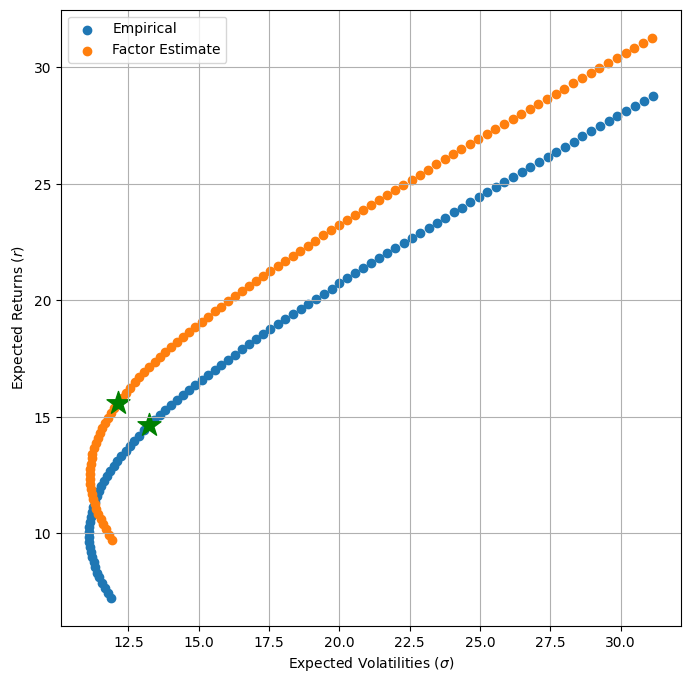

In [16]:
efport_dict = {"Empirical": efport_emp, "Factor Estimate": efport_f}

plot_efficient_frontier(efport_dict=efport_dict)

# 6. Market Capitalization

In [17]:
mcap_eval = MarketCapEvaluator(tickers=ASSET_TICKERS["stock"])
market_cap_stocks = mcap_eval.compute_market_cap()
market_cap_stocks

{'AAPL': 0.42814877458330025,
 'IBM': 0.021093355204418136,
 'PG': 0.054404015471938925,
 'GE': 0.01625265860619555,
 'AMD': 0.03217556851197645,
 'WMT': 0.06524030122853494,
 'BAC': 0.038056562514177834,
 'T': 0.017453618870999454,
 'XOM': 0.06632434964348748,
 'RRC': 0.0010973899369594732,
 'BBY': 0.002437559915826505,
 'PFE': 0.028335725155624675,
 'JPM': 0.06921670216330111,
 'C': 0.014231291579372703,
 'MCD': 0.031414580149750085,
 'KO': 0.039124016020101494,
 'JNJ': 0.06051033342170055,
 'WHR': 0.0010364467615684566,
 'MMM': 0.007119014219436203,
 'GIS': 0.006327736041329773}

# 7. Evaluate MSR Portfolio Performance

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculate Alpha : AAPL (Fama French Model)--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
------

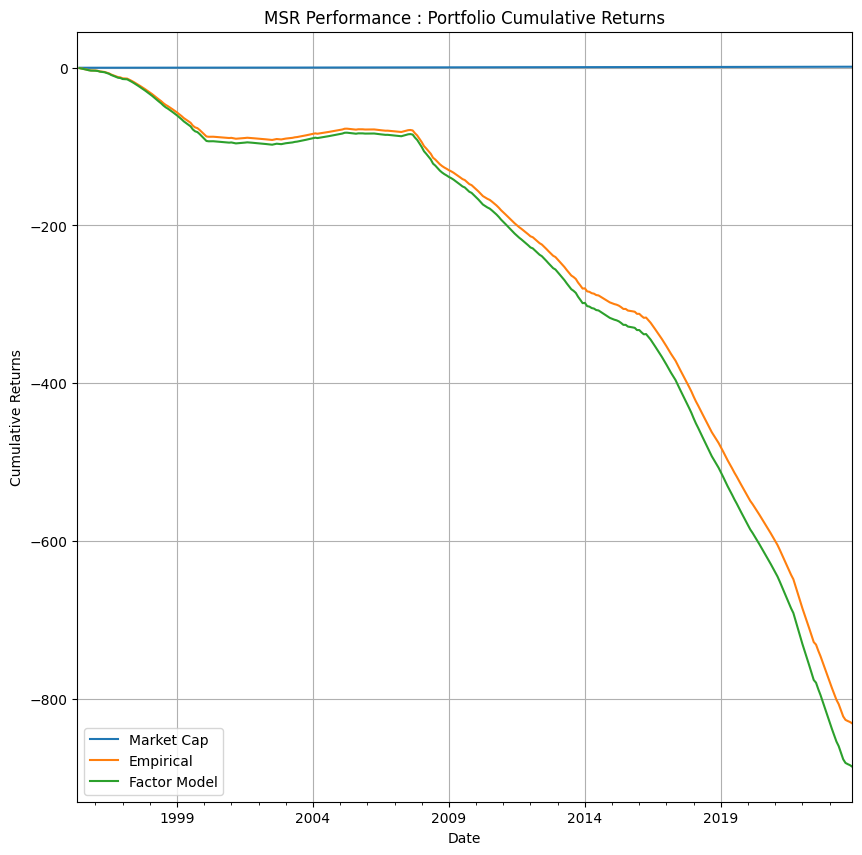

,Total Profit,Annual Returns,Annual Volatility,Sharpe Ratio,Information Ratio
0,1.298005,0.029238,0.003941,7.418,-0.49815


,Total Profit,Annual Returns,Annual Volatility,Sharpe Ratio,Information Ratio
0,-831.352541,1.45107,6.514152,0.222757,0.206314


,Total Profit,Annual Returns,Annual Volatility,Sharpe Ratio,Information Ratio
0,-886.234571,0.462931,1.342458,0.344838,0.263688


In [18]:
allocations_dict = {
    "Market Cap": market_cap_stocks,
    "Empirical" : optimal_weights_emp,
    "Factor Model": optimal_weights_f,
}
performance = backtest(allocations_dict, factors=FF_FACTORS, asset_type=asset_type)

display(performance["Market Cap"])
display(performance["Empirical"])
display(performance["Factor Model"])